<div style="text-align: center;">    
 <h2 style="color:red"> $\ll\!\!\prec\quad$ Examen Módulo II $\quad\succ\!\!\gg$ </h2>

 <h3 style="color:blue"> $\ll\!\!\prec\quad$ Andrés Padrón Quintana $\quad\succ\!\!\gg$ </h3>
</div>


**Instrucciones**: Resuelva las siguientes preguntas y envíe sus respuestas al correo danielrs98@outlook.com a
más tardar el miércoles 03 de septiembre de 2025 a las 11:59pm. Las respuestas deberán ir acompañados del código
en Python correspondiente, de preferencia en un zip que contenga un notebook con todas las soluciones
(archivo .ipynb).

En el asunto del correo, favor de poner su nombre

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import yfinance as yf
from scipy.optimize import minimize
from sklearn.decomposition import PCA

## 1.- ##
Hace 1 año invertiste 250,000 USD en Apple, 250,000 USD en HSBC, 250,000 USD en Pfizer y 250,000 USD en Costco, lo que nos da un total de 1,000,000 USD invertidos. Para las siguientes preguntas supondremos que se pueden comprar fracciones de acciones, una distribución normal de los retornos y para calcular los retornos y desviación estándar del portafolio deberás hacerlo en función de sus componentes (MPT). Dado lo anterior y situándonos al día de hoy, responde:
- a) ¿Cuál es el valor actual de tu portafolio?
- b) Realiza un histograma de los retornos del portafolio.
- c) ¿Cuál es el retorno esperado diario y el retorno esperado mensual de tu portafolio?
- d) ¿Cuál es la desviación estándar de los retornos diarios y retornos mensuales de tu portafolio?
- e) ¿Cuál es el portafolio de Mín Varianza? 
- f) ¿Cuál es el portafolio de Máx S-R?
- g) Muestre la frontera eficiente de su portafolio

In [8]:
# a)

# Definimos los tickers
tickers = ["AAPL", "HSBC", "PFE", "COST"]

# Descargamos los datos con yf
datos_brutos = yf.download(
    tickers, period="1y", auto_adjust=True, progress=False
)

# Extraemos columna 'Close' (ya ajustada por splits/dividendos)

if isinstance(datos_brutos.columns, pd.MultiIndex):
    precios = datos_brutos["Close"].copy()   # columnas = tickers
else:
    # Si fuera un solo ticker, aseguramos DataFrame con el nombre del ticker
    if "Close" in datos_brutos.columns:
        precios = datos_brutos[["Close"]].copy()
        if len(tickers) == 1:
            precios.columns = [tickers[0]]
    else:
        raise ValueError("No se encontró la columna 'Close' en la descarga de datos.")

# 3) Hacemos limpieza
precios = precios.dropna(how="all")
assert not precios.empty, "No se descargaron precios válidos."

# 4) Calculamos los retornos logarítmicos diarios
retornos = np.log(precios / precios.shift(1)).dropna()

precios.head(), retornos.head()

(Ticker            AAPL        COST       HSBC        PFE
 Date                                                    
 2024-08-28  225.440796  883.515930  41.481846  26.864941
 2024-08-29  228.725494  882.103271  41.632858  26.836908
 2024-08-30  227.939163  887.823914  41.963200  27.107895
 2024-09-03  221.738037  874.084351  40.981602  26.444445
 2024-09-04  219.826935  885.475891  41.104305  26.528545,
 Ticker          AAPL      COST      HSBC       PFE
 Date                                              
 2024-08-29  0.014465 -0.001600  0.003634 -0.001044
 2024-08-30 -0.003444  0.006464  0.007903  0.010047
 2024-09-03 -0.027582 -0.015597 -0.023670 -0.024779
 2024-09-04 -0.008656  0.012948  0.002990  0.003175
 2024-09-05  0.006904 -0.004550  0.008915  0.004218)

In [9]:
# Definimos la inversión inicial y los precios para cada ticker

inversion_inicial = 1_000_000
pesos_iguales = np.array([0.25, 0.25, 0.25, 0.25])  # 250,000 para cada uno

# Calculamos el número de acciones compradas hace 1 año
acciones = (inversion_inicial * pesos_iguales) / precios.iloc[0]

# Valor actual del portafolio
valor_portafolio = np.sum(acciones * precios.iloc[-1])
valor_portafolio

1144362.0900007533

Por lo tanto, el portafolio generó valor y estuvo bien dicersificado.

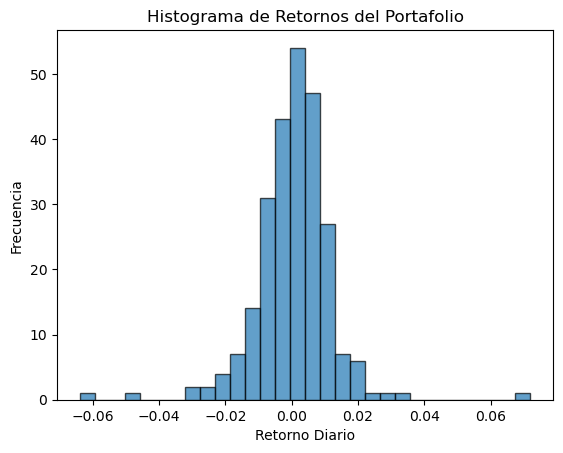

In [10]:
# b)

# Definimos los retornos  del portafolio como retorno diario del portafolio
retornos_portafolio = retornos.dot(pesos_iguales)

plt.hist(retornos_portafolio, bins=30, edgecolor="black", alpha=0.7)
plt.title("Histograma de Retornos del Portafolio")
plt.xlabel("Retorno Diario")
plt.ylabel("Frecuencia")
plt.show()

- La mayoría de los retornos diarios del portafolio están concentrados cerca de 0%.

- Se observa una distribución con forma de campana (aproximadamente normal), pero con algunos valores extremos a la izquierda (–6%) y a la derecha (+6–7%), que reflejan eventos poco frecuentes de alta volatilidad.

- Esto es típico en activos financieros: no son perfectamente normales, tienen colas pesadas

In [11]:
# c)

retorno_esp_diario = retornos_portafolio.mean()
retorno_esp_mensual = retorno_esp_diario * 21  # aprox. 21 días hábiles al mes

retorno_esp_diario, retorno_esp_mensual

(0.0004532541731127854, 0.009518337635368494)

En promedio, el portafolio gana 0.045% por día hábil.

Eso se traduce en 0.95% al mes (casi 1% mensual).

Si anualizamos (multiplicando por ~252 días hábiles): 0.114⇒11.4% esperado anual

Lo cual coincide con el resultado del valor actual (inciso a) (~14% en un año).

In [12]:
# d)

desv_diaria = retornos_portafolio.std()
desv_mensual = desv_diaria * np.sqrt(21)

desv_diaria, desv_mensual

(0.01165196337551055, 0.05339600416313025)

- El riesgo diario del portafolio es de ±1.17% en promedio.

- El riesgo mensual es de ±5.34%, lo que significa que en un mes cualquiera, el portafolio puede variar alrededor de su retorno esperado con esa magnitud.

- Esto es un nivel de volatilidad moderado, mucho menor que la de un activo individual como Apple o Pfizer, porque la diversificación redujo el riesgo.

In [13]:
# e)

# Calculamos media y covarianza
media_retornos = retornos.mean()
matriz_cov = retornos.cov()

# Función para calcular retorno y volatilidad de un portafolio
def desempeño_portafolio(pesos):
    retorno = np.dot(pesos, media_retornos)
    volatilidad = np.sqrt(np.dot(pesos.T, np.dot(matriz_cov, pesos)))
    return retorno, volatilidad

# Calculamos la varianza
def varianza_portafolio(pesos):
    return desempeño_portafolio(pesos)[1]**2

# Ponemos la restricción de que los pesos tienen que sumar 1
restricciones = ({'type':'eq', 'fun': lambda w: np.sum(w) - 1})

# Ponemos la restricción de: no ventas en corto (0 <= w <= 1)
limites = tuple((0,1) for _ in range(len(media_retornos)))

# Optimizamos
resultado_minvar = minimize(
    varianza_portafolio,
    x0 = len(media_retornos) * [1./len(media_retornos)], # start = pesos iguales
    method = "SLSQP",
    bounds = limites,
    constraints = restricciones
)

pesos_minvar = resultado_minvar.x
desempeño_minvar = desempeño_portafolio(pesos_minvar)

pesos_minvar, desempeño_minvar


(array([0.25, 0.25, 0.25, 0.25]), (0.0004532541731127854, 0.01165196337551055))

- El portafolio de mínima varianza es exactamente el portafolio igualmente ponderado.
(Esto pasa cuando los activos tienen correlaciones y volatilidades similares, y el balance natural ya es óptimo).

- Desempeño de ese portafolio:

Retorno esperado diario ≈ 0.00045 (0.045%)

Volatilidad diaria ≈ 0.01165 (1.17%)

In [14]:
# f)

# Definimos la función que calcula la razón de Sharpe
def sharpe_negativo(pesos):
    retorno, volatilidad = desempeño_portafolio(pesos)
    return -retorno / volatilidad

# Optimizamos
resultado_maxsharpe = minimize(
    sharpe_negativo,
    x0 = len(media_retornos) * [1./len(media_retornos)],
    method = "SLSQP",
    bounds = limites,
    constraints = restricciones
)

pesos_maxsharpe = resultado_maxsharpe.x
desempeño_maxsharpe = desempeño_portafolio(pesos_maxsharpe)

pesos_maxsharpe, desempeño_maxsharpe

(array([2.0816682e-17, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00]),
 (0.0017931394835695046, 0.015425526650371661))

El portafolio óptimo de Sharpe invierte el 100% en Pfizer (PFE), y 0% en Apple, HSBC y Costco.

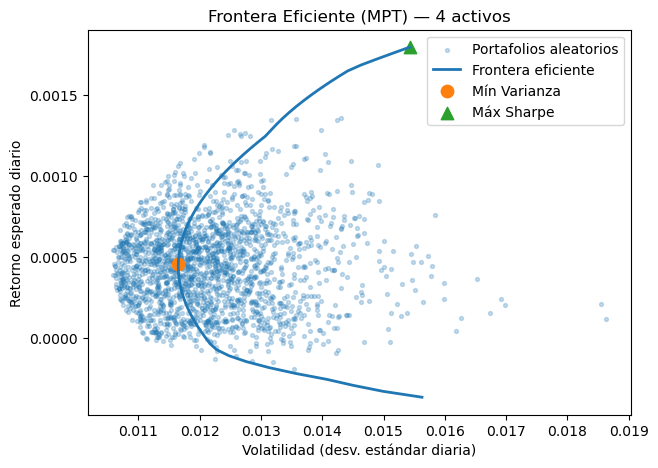

In [16]:
# g)

# Construimos la frontera eficiente resolviendo la varianza mínima para un conjunto de retornos objetivo
retornos_objetivo = np.linspace(media_retornos.min(), media_retornos.max(), 60)
volatilidades = []

for r in retornos_objetivo:
    restricciones_frontera = (
        {'type':'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type':'eq', 'fun': lambda w, r=r: np.dot(w, media_retornos) - r}
    )
    res = minimize(
        varianza_portafolio,
        x0 = len(media_retornos) * [1./len(media_retornos)],
        method = "SLSQP",
        bounds = limites,
        constraints = restricciones_frontera
    )
    volatilidades.append(np.sqrt(res.fun))

# Calculamos desempeño (retorno, volatilidad) de ambos portafolios óptimos
ret_minvar, vol_minvar = desempeño_portafolio(pesos_minvar)
ret_maxsharpe, vol_maxsharpe = desempeño_portafolio(pesos_maxsharpe)

# Nubes de portafolios aleatorios para contexto visual
rng = np.random.default_rng(0)
ret_rand = []
vol_rand = []
for _ in range(2000):
    w = rng.random(len(media_retornos))
    w = w / w.sum()
    r_, v_ = desempeño_portafolio(w)
    ret_rand.append(r_)
    vol_rand.append(v_)

# Graficamos
plt.figure(figsize=(7,5))
plt.scatter(vol_rand, ret_rand, alpha=0.25, s=8, label="Portafolios aleatorios")
plt.plot(volatilidades, retornos_objetivo, linewidth=2, label="Frontera eficiente")
plt.scatter([vol_minvar], [ret_minvar], s=80, marker="o", label="Mín Varianza")
plt.scatter([vol_maxsharpe], [ret_maxsharpe], s=80, marker="^", label="Máx Sharpe")
plt.title("Frontera Eficiente (MPT) — 4 activos")
plt.xlabel("Volatilidad (desv. estándar diaria)")
plt.ylabel("Retorno esperado diario")
plt.legend()
plt.show()

## 2.- ##
Considera los siguientes índices globales: DAX, NASDAQ 100, Hang Seng, FTSE 100, IPC Mexico, y obtén sus niveles históricos de mínimo 5 años (de preferencia utilizando la API de Yahoo Finance). Con esta información:
- a) Haz una gráfica comparando el cambio porcentual de todos los índices.
- b) Obtén la matriz de correlación y explica, a grandes rasgos, qué es lo que se observa.
- c) Realiza un PCA sobre los retornos de los índices y calcula el porcentaje de varianza explicada por cada componente principal.
- d) ¿Qué información podemos obtener de los componentes principales obtenidos?


[*********************100%***********************]  5 of 5 completed


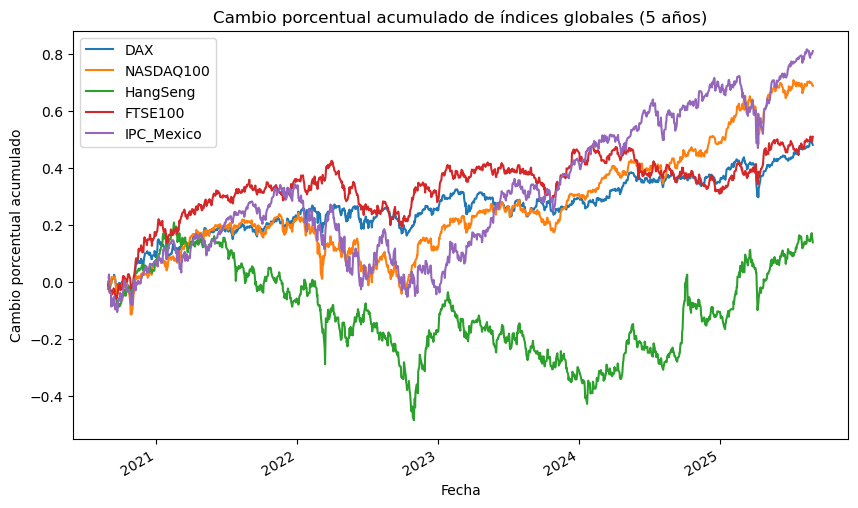

In [17]:
# a)

# Definimos los tickers de índices
indices = {
    "DAX": "^GDAXI",
    "NASDAQ100": "^NDX",
    "HangSeng": "^HSI",
    "FTSE100": "^FTSE",
    "IPC_Mexico": "^MXX"
}

# Descargamos de precios 5 años
precios_indices = yf.download(list(indices.values()), period="5y", auto_adjust=True)["Close"]

# Cambio porcentual acumulado
cambio_pct = precios_indices.pct_change().cumsum()

# Graficamos
cambio_pct.plot(figsize=(10,6))
plt.title("Cambio porcentual acumulado de índices globales (5 años)")
plt.ylabel("Cambio porcentual acumulado")
plt.xlabel("Fecha")
plt.legend(indices.keys())
plt.show()

En los últimos 5 años, el IPC México y el NASDAQ 100 son los que más han crecido, con un cambio porcentual acumulado cercano al +70%–80%.

El FTSE 100 y el DAX muestran crecimientos más moderados, alrededor de +40%.

El Hang Seng destaca negativamente: presenta caídas significativas y, aunque se ha recuperado un poco en 2024–2025, aún se mantiene muy por debajo de su nivel de inicio (incluso llegó a –40% en 2022).

Matriz de correlación de los índices:

Ticker     ^FTSE    ^GDAXI      ^HSI      ^MXX      ^NDX
Ticker                                                  
^FTSE   1.000000  0.757756  0.285306  0.341563  0.217737
^GDAXI  0.757756  1.000000  0.246407  0.346333  0.371867
^HSI    0.285306  0.246407  1.000000  0.183702  0.116757
^MXX    0.341563  0.346333  0.183702  1.000000  0.363586
^NDX    0.217737  0.371867  0.116757  0.363586  1.000000


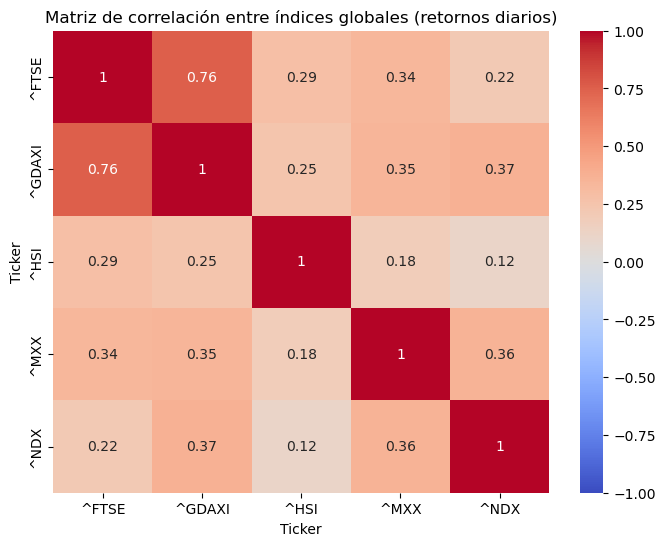

In [18]:
# b)

# Calculamos retornos diarios (porcentuales)
retornos_indices = precios_indices.pct_change().dropna()

# Matriz de correlación
matriz_corr = retornos_indices.corr()

print("Matriz de correlación de los índices:\n")
print(matriz_corr)

# Graficamos mapa de calor 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(matriz_corr, annot=True, cmap="coolwarm", center=0, vmin=-1, vmax=1)
plt.title("Matriz de correlación entre índices globales (retornos diarios)")
plt.show()


- FTSE 100 y GDAX (0.76): muy alta correlación → refleja que ambos son mercados europeos y reaccionan de manera similar a factores económicos y financieros comunes (tasas BCE, energía, inflación).

- NASDAQ con DAX y MXX (~0.36–0.37): correlación moderada → muestra que EE.UU. y México están conectados financieramente, y que el mercado europeo también sigue de cerca a EE.UU.

- Hang Seng con los demás (~0.12–0.29): baja correlación → Asia sigue su propia dinámica, más influida por factores locales (China, Hong Kong), lo que lo hace más independiente de los shocks de Europa y América.

- IPC México con NASDAQ (0.36): relación moderada-alta, consistente con la dependencia económica mexicana hacia EE.UU.

In [20]:
# c)

# Usamos los retornos diarios ya calculados

# Aplicamos PCA
pca = PCA()
pca.fit(retornos_indices)

# Varianza explicada por cada componente
var_exp = pca.explained_variance_ratio_

# Creamos tabla con resultados
tabla_pca = pd.DataFrame({
    "Componente": [f"PC{i+1}" for i in range(len(var_exp))],
    "Varianza_Explicada": var_exp,
    "Varianza_Acumulada": np.cumsum(var_exp)
})

print(tabla_pca)

  Componente  Varianza_Explicada  Varianza_Acumulada
0        PC1            0.444179            0.444179
1        PC2            0.280290            0.724469
2        PC3            0.156260            0.880729
3        PC4            0.092624            0.973353
4        PC5            0.026647            1.000000


In [21]:
# d)

- PC1 (44.4%) → representa el factor global de mercado, es decir, el movimiento común de los índices ante shocks internacionales (tasas de interés, inflación, recesiones globales).

- PC2 (28.0%) → refleja diferencias regionales: típicamente distingue entre mercados desarrollados (NASDAQ, DAX, FTSE) y emergentes (México, Hong Kong).

- PC3 (15.6%) → puede capturar un factor asiático específico (Hang Seng), que ya vimos tiene menor correlación con los demás.

- PC4 (9.3%) y PC5 (2.7%) → representan factores idiosincráticos (ruido o particularidades locales de cada índice).

- Los dos primeros componentes (PC1 + PC2) explican 72.4% de la varianza total

## 3.- ##
Queremos valuar un call “asiático” con vencimiento en 1 año y strike de \\$110. En este tipo de opciones el payoff depende del promedio del precio del subyacente. Supongamos que este call va a depender del promedio mensual por lo que:  
$$ \begin{align} Payoff = max[0, (\frac{1}{12}\sum_{t=1}^{12} S_t) - K] \end{align} $$  

Además, supongamos que los retornos de cualquier mes son independientes y siempre se distribuyen como una normal con media igual a 5% y desviación estándar igual a 10%. Al iniciar el contrato el precio del subyacente se encuentra en $220. Considerando esto:
- a) Realiza las simulaciones para obtener 1000 payoffs diferentes y haz una gráfica en la que muestres los diferentes caminos que puede seguir el precio del subyacente de acuerdo a las simulaciones.
- b) Calcula el valor de la prima de la opción (no es necesario traer a valor presente). 

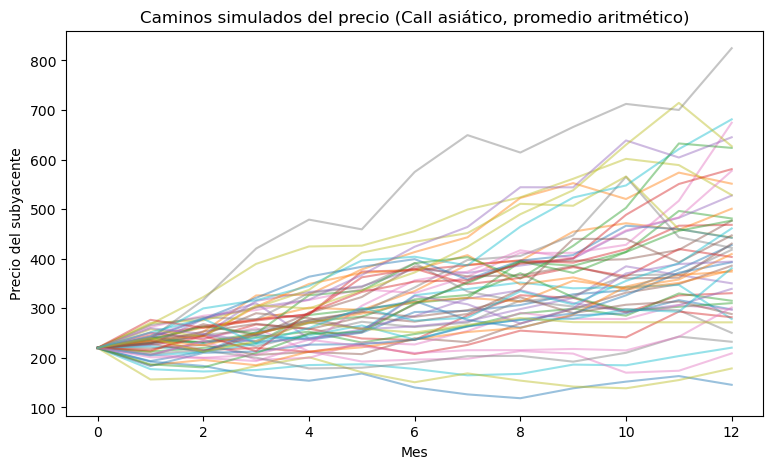

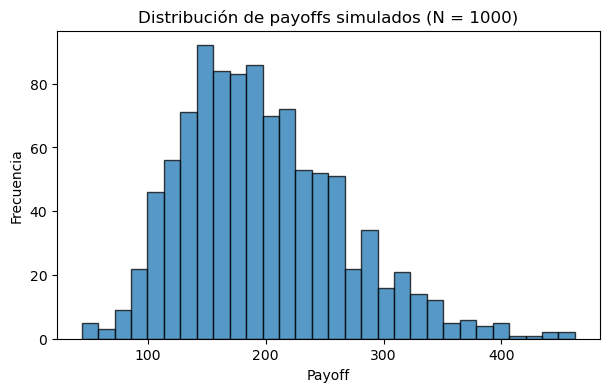

In [2]:
# Definimos los parámetros del problema
S0 = 220.0
K = 110.0
mu_mensual = 0.05       # media de retornos(normal)
sigma_mensual = 0.10    # desviación estándar
meses = 12
n_sims = 1000
rng = np.random.default_rng(197485)  # para reproducibilidad

# a) Simulamos trayectorias y payoffs
# Retornos ~ N(mu, sigma)  (independientes por mes y simulación)
retornos_sim = rng.normal(loc=mu_mensual, scale=sigma_mensual, size=(n_sims, meses))

# Calculamos la matriz de precios: columnas 0..12, donde col 0 es S0
precios = np.empty((n_sims, meses + 1))
precios[:, 0] = S0
for t in range(1, meses + 1):
    precios[:, t] = precios[:, t-1] * (1 + retornos_sim[:, t-1])

# Sacamos el promedio aritmético mensual (excluye S0)
promedios_mensuales = precios[:, 1:].mean(axis=1)

# Payoff asiático
payoffs = np.maximum(promedios_mensuales - K, 0.0)

# Graficamos los caminos
plt.figure(figsize=(9,5))
for i in range(min(50, n_sims)):
    plt.plot(range(meses + 1), precios[i, :], alpha=0.45)
plt.title("Caminos simulados del precio (Call asiático, promedio aritmético)")
plt.xlabel("Mes")
plt.ylabel("Precio del subyacente")
plt.show()

# Histograma de payoffs
plt.figure(figsize=(7,4))
plt.hist(payoffs, bins=30, edgecolor="black", alpha=0.75)
plt.title("Distribución de payoffs simulados (N = 1000)")
plt.xlabel("Payoff")
plt.ylabel("Frecuencia")
plt.show()


Algunos caminos crecen mucho (por arriba de 600–700), otros se quedan cercanos a 200, y unos pocos bajan, aunque ninguno cae demasiado (strike = 110 queda muy por debajo de casi todos los promedios).

Esto refleja la alta dispersión de resultados al simular 12 meses de evolución.

La mayoría de los payoffs está entre 100 y 250.

La distribución tiene cola derecha: en algunos escenarios el promedio mensual es muy alto y el payoff supera los 300–400.

In [5]:
# b) Prima estimada por Monte Carlo (sin descontar)
prima_mc = payoffs.mean()

prima_mc

197.3057734517012

Esto significa que, dado que el strike K=110 es bastante bajo respecto al precio inicial S0=220, la opción casi siempre termina in-the-money, generando un valor elevado.

El resultado es coherente con el histograma de payoffs, donde la mayoría de los valores estaban en el rango 100–250.

## 4.- ## 

La regresión lineal se puede utilizar para estimar la razón óptima de cobertura. Generalmente en los longshort hedge funds se intenta obtener ganancias de las diferencias entre diferentes firmas más no de los retornos del mercado en general. Dado esto se puede utilizar una cobertura para eliminar el riesgo del mercado general.  
El modelo de regresión utilizado para estimar la cobertura óptima es:
$$ R_{port} = \alpha + \beta R_{cober} + \epsilon $$  
En donde $ R_{port} $ es el retorno del portafolio a cubrir y $ R_{cober} $ es el retorno del instrumento de cobertura.
- a) Utilizando retornos mensuales de un período de 10 años, implementa la regresión lineal para 3 distintos portafolios (de fondos de inversión): Financial Select Sector SPDR Fund (XLF), Energy Select Sector SPDR Fund (XLE) y Consumer Staples Select Sector SPDR Fund (XLP). Considera como instrumento de cobertura el SPDR S&P 500 ETF Trust (SPY).
- b) En este modelo, ¿cuál sería la interpretación de los parámetros 𝛼 y 𝛽?
- c) Si se realizarán las coberturas utilizando el modelo implementado, ¿cuál de los fondos tendría una mayor disminución en la desviación estándar de sus retornos?

In [6]:
# a)
# Definimos los portafolios (sectores) y cobertura (SPY)
tickers = {"XLF":"XLF", "XLE":"XLE", "XLP":"XLP", "SPY":"SPY"}

# Descargamos de manera mensual 10 años (precios ajustados de cierre)
datos = yf.download(list(tickers.values()), period="10y", interval="1mo", auto_adjust=True, progress=False)

# Extraemos 'Close' de forma robusta y renombrar columnas a claves (XLF, XLE, XLP, SPY)
if isinstance(datos.columns, pd.MultiIndex):
    precios = datos["Close"].copy()
else:
    precios = datos[["Close"]].copy()
precios = precios.rename(columns={v:k for k,v in tickers.items()})

# Retornos mensuales simples
retornos_m = precios.pct_change().dropna(how="any")

# Definimos una función de regresión OLS (Mínimos Cuadrados)
def regresion_lineal_simple(y, x):
    beta = np.cov(x, y, ddof=1)[0,1] / np.var(x, ddof=1)
    alpha = y.mean() - beta * x.mean()
    y_aj = alpha + beta * x
    resid = y - y_aj
    r2 = 1 - np.var(resid, ddof=1) / np.var(y, ddof=1)
    return alpha, beta, r2, resid

# Ejecutamos la regresión para cada fondo vs SPY
resultados = {}
for fondo in ["XLF", "XLE", "XLP"]:
    a, b, r2, resid = regresion_lineal_simple(retornos_m[fondo], retornos_m["SPY"])
    desv_sin_cob = retornos_m[fondo].std(ddof=1)
    desv_con_cob = resid.std(ddof=1)                 # sd de los residuales ≈ sd con cobertura
    reduccion = desv_sin_cob - desv_con_cob          # cuánto baja la desviación
    resultados[fondo] = {
        "alpha": a, "beta": b, "R2": r2,
        "desv_sin_cob": desv_sin_cob,
        "desv_con_cob": desv_con_cob,
        "reduccion": reduccion
    }

tabla_resultados = pd.DataFrame(resultados).T
tabla_resultados

,alpha,beta,R2,desv_sin_cob,desv_con_cob,reduccion
XLF,-0.001354,1.083161,0.706742,0.058081,0.031453,0.026628
XLE,-0.004856,1.215119,0.384827,0.088300,0.069256,0.019044
XLP,0.000195,0.569311,0.479311,0.037069,0.026749,0.010321


XLF es el fondo más correlacionado con el mercado (alto Rˆ2) y logra la mayor reducción de riesgo al cubrir con SPY.

XLE es más volátil, pero su relación con el SPY es débil, por lo que la cobertura no le ayuda tanto.

XLP es defensivo y menos volátil desde el inicio, por lo que aunque mejora con la cobertura, su reducción es la menor en términos absolutos.

b)

- α (alpha):

Representa el rendimiento promedio independiente del mercado.

Si es positivo → indica un exceso de retorno (rendimiento adicional no explicado por SPY).

Si es negativo → indica un sesgo negativo en el retorno respecto al mercado.

Los alphas son cercanos a 0, lo que significa que los tres fondos no generan exceso de retorno significativo más allá de lo que explica SPY.


- β (beta):

Mide la sensibilidad del fondo al mercado (SPY).

Es la razón óptima de cobertura: para cubrir 1 USD en el fondo, se toma una posición −β en SPY.

Interpretación para cada fondo:

XLF (β ≈ 1.08): se mueve casi igual que el mercado, un poco más agresivo.

XLE (β ≈ 1.22): amplifica los movimientos del mercado, es el más volátil de los tres.

XLP (β ≈ 0.57): defensivo, mucho menos sensible al mercado.

c) 

-El fondo que logra la mayor disminución en la desviación estándar de sus retornos al aplicar la cobertura es XLF (sector financiero), porque es el más correlacionado con el mercado general. 

-Aunque XLE (sector energético) es el más volátil en términos absolutos, su Rˆ2 es baja. 

-Por último, XLP (consumo básico) al cubrir con SPY sí reduce algo de riesgo, pero el efecto es modesto en términos absolutos